# This notebook deal with uncalibrated cosmic standard rulers and candles

In [2]:
#Show plots inline, and load main getdist plot module and samples class
### Need to run the following twice for some unknown reason. Otherwise plot wouldn't show
from __future__ import print_function
from IPython.display import display, Math
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples, loadMCSamples
import getdist, IPython
import pylab as plt
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))
#matplotlib 2 doesn't seem to work well without usetex on
plt.rcParams['text.usetex']=True
import numpy as np
import WLbackground_cosmic_stds as BG
import WLlikelihoods_cosmic_stds as LIKE
import scipy.optimize as op
import emcee
from scipy import integrate
import time
from matplotlib import ticker, cm, patches, pyplot
import pandas as pd


GetDist Version: 1.1.2, Matplotlib version: 3.2.2


# Loading SNIa data:

In [ ]:
pantheon_path='Pantheon_data/lcparam_full_long_zhel.txt'
pantheon0 = pd.read_csv(pantheon_path, sep=" ", header=0)
pantheon = pantheon0[['name','zcmb','mb','dmb']]
pantheon = pantheon.sort_values(by='zcmb')    # sort SNIa in a z-ascending order for the new algorithm
pantheon = pantheon.reset_index()             # have to reset the index, otherwise the index is not sorted

Npan = len(pantheon.zcmb)   # number of all SN
z_obs = pantheon.zcmb       # redshift
m_obs = pantheon.mb         # apparent magnitude
dm_obs = pantheon.dmb       # uncertainty of m

pan_sys=np.loadtxt("Pantheon_data/sys_full_long_sort.txt")   # systematic errors, pre-sorted

C_pan = pan_sys+np.diag(pantheon.dmb**2) # total errros, including statistic and systematic errors

# Moore-Penrose pseudo-inverse
invC_pan = np.linalg.inv(C_pan)    # CHECK! In case the inverse doesn't work

# Best fits to SNIa data:

In [ ]:
start_time = time.time()

nll = lambda *args: -LIKE.lnprob_SN(*args)   # load likelihood
use_fast = True      # use fast likelihood or not       
SN_data = pantheon
invC = invC_pan

result = op.minimize(nll, [24, 0.3], args=(SN_data,invC,use_fast))
MH0_best = result["x"][0]     # MH0=M-5log10(10pc*H0)  #c=1, this is the same as C in the likelihood functions
# MH0 here is a combination of H0 and the absolute magnitude shifted to zero color and zero strecth. 
Om_best = result["x"][1]
print("Best fits: %2.6f, %1.7f" % (MH0_best, Om_best))

print("--- %s seconds ---" % (time.time() - start_time))

# MCMC to SNIa likelihood:
# In LCDM, SNIa likelihood has two parameters: MH0, Om

In [ ]:
# Run the above best fits first:

ndim, nwalkers, nstep = 2, 32, 500  # settings for emcee
use_fast = True   # use the fast likelihood or not
SN_data = pantheon
invC = invC_pan

# set the path/file to save the chain:
save_chain_file = 'chains/Fast1_walkers'+str(nwalkers)+'_step'+str(nstep)+'.csv'
    
# MCMC 
pos = [[MH0_best*(1+0.0004*np.random.randn()),Om_best*(1+0.01*np.random.randn())] for i in range(nwalkers)]

sampler_SN=emcee.EnsembleSampler(nwalkers, ndim, LIKE.lnprob_SN, args=(SN_data,invC,use_fast))
sampler_SN.run_mcmc(pos, nstep, progress=True,);

samples_SN = sampler_SN.chain[:, 50:, :].reshape((-1, ndim))   #filter out first XXX rows

np.savetxt(save_chain_file, samples_SN, delimiter=',')

# Caculate summary statistics to SN likelihood:

In [ ]:
load_chain_file = save_chain_file  # choose file to load
samples = np.loadtxt(load_chain_file,delimiter=",")

# Saving Median and upper and lower limits
MH0_median_low_high, Om_median_low_high = map(lambda v: ((v[1], v[2]-v[1], v[1]-v[0])), 
                           zip(*np.percentile(samples, [16, 50, 84], axis=0))) # median + upper - lower
    
# Saving means and uncertainty
MH0_mean, Om_mean = np.mean(samples,axis=0)
MH0_std, Om_std = np.std(samples,axis=0)
    
print('Median+upper-lower:')
# display median + upper -lower of C
for MEDIAN, PARAM in zip([MH0_median_low_high, Om_median_low_high], 
                         ['M-5\log_{10}(10{\\rm{pc}}\\times H_0)','\Omega_{\mathrm{m}}']):
    txt = "{3} = {{{0: 2.3f}}}^{{+{1: .3f}}}_{{-{2: .3f}}}"
    txt = txt.format(MEDIAN[0], MEDIAN[1], MEDIAN[2], PARAM)
    display(Math(txt))

# display mean+-uncertainty
print('Mean+-uncertainty:')
for MEAN, STD, PARAM in zip([MH0_mean, Om_mean], [MH0_std, Om_std],
                            ['M-5\log_{10}(10{\\rm{pc}}\\times H_0)', '\Omega_{\mathrm{m}}']):
    txt = "{2} = {0: 2.3f}\pm{1: .3f}"
    txt = txt.format(MEAN, STD, PARAM)
    display(Math(txt))

In [ ]:
names = [r'MH0', 'Omegam']    # put parameters here
labels =  [r'$M-5\log_{10}(10{\rm{pc}}\times H_0)$',r'$\Omega_m$']    # label parameters here
MCsamples = MCSamples(samples=samples,names = names, labels = labels)
g = plots.getSinglePlotter(width_inch=5, ratio=1)
g.triangle_plot(MCsamples, ['MH0','Omegam'],shaded=True)
g.export(os.path.join(r'figures',r'pantheon_C_Om.pdf'))

# BAO data likelihood

# Best fit to BAO

In [36]:
start_time = time.time()

nll = lambda *args: -LIKE.lnprob_BAO(*args)   # load likelihood
BAO_data_path='BAO_data/'
BAO_datasets = ['6df','DR7_MGS','DR12_consensus','DR14_qsar','DR14_lya_qsar','DR16_LRG_ELG']

result = op.minimize(nll, [0.034, 0.3], args=(BAO_data_path,BAO_datasets))
rdH0_best = result["x"][0]     # MH0=M-5log10(10pc*H0)  #c=1, this is the same as C in the likelihood functions
# MH0 here is a combination of H0 and the absolute magnitude shifted to zero color and zero strecth. 
Om_best = result["x"][1]
print("Best fits: %2.6f, %1.7f" % (rdH0_best, Om_best))

print("--- %s seconds ---" % (time.time() - start_time))

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Best fits: 0.033743, 0.2944976
--- 0.44789934158325195 seconds ---


# MCMC to BAO:
# Late-time BAO has two parameters: rdH0 and Om

In [225]:
# Run the above best fits first:

ndim, nwalkers, nstep = 2, 64, 4000  # settings for emcee
BAO_data_path='BAO_data/'

BAO_datasets=['6df','DR7_MGS','DR12_consensus','DR16_LRG_ELG','DR14_qsar','DR14_lya_qsar']
# set the path/file to save the chain:
save_chain_file_BAO = 'chains/BAO_only/AllBAO_walkers'+str(nwalkers)+'_step'+str(nstep)+'.csv'
# MCMC 
pos = [[rdH0_best*(1+0.01*np.random.randn()),Om_best*(1+0.06*np.random.randn())] for i in range(nwalkers)]
sampler_BAO=emcee.EnsembleSampler(nwalkers, ndim, LIKE.lnprob_BAO, args=(BAO_data_path,BAO_datasets))
sampler_BAO.run_mcmc(pos, nstep, progress=True,);
samples_BAO = sampler_BAO.chain[:, :, :].reshape((-1, ndim))   #filter out first XXX rows
np.savetxt(save_chain_file_BAO, samples_BAO, delimiter=',')

100%|██████████| 4000/4000 [13:54<00:00,  4.79it/s]


# Calculate Summary statistics:

In [232]:
load_chain_file = 'chains/BAO_only/AllBAO_walkers'+str(nwalkers)+'_step'+str(nstep)+'.csv'  # choose file to load
samples = np.loadtxt(load_chain_file,delimiter=",")

# Saving Median and upper and lower limits
rdH0_median_low_high, Om_median_low_high = map(lambda v: ((v[1], v[2]-v[1], v[1]-v[0])), 
                           zip(*np.percentile(samples, [16, 50, 84], axis=0))) # median + upper - lower
    
# Saving means and uncertainty
rdH0_mean, Om_mean = np.mean(samples,axis=0)
rdH0_std, Om_std= np.std(samples,axis=0)
    
print('Median+upper-lower:')
# display median + upper -lower of rdH0
for MEDIAN, PARAM in zip([rdH0_median_low_high, Om_median_low_high], ['r_{\\rm{d}}H_0',
                                                                     '\Omega_{\mathrm{m}}']):
    txt = "{3} = {{{0: 2.4f}}}^{{+{1: .4f}}}_{{-{2: .4f}}}"
    txt = txt.format(MEDIAN[0], MEDIAN[1], MEDIAN[2], PARAM)
    display(Math(txt))

# display mean+-uncertainty
print('Mean+-uncertainty:')
for MEAN, STD, PARAM in zip([rdH0_mean, Om_mean], [rdH0_std, Om_std], [' r_{\\rm{d}}H_0', '\Omega_{\mathrm{m}}']):
    txt = "{2} = {0: 2.5f}\pm{1: .5f}"
    txt = txt.format(MEAN, STD, PARAM)
    display(Math(txt))
    


Median+upper-lower:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Mean+-uncertainty:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Plotting BAO MCMC:

Removed no burn in


<Figure size 360x360 with 0 Axes>

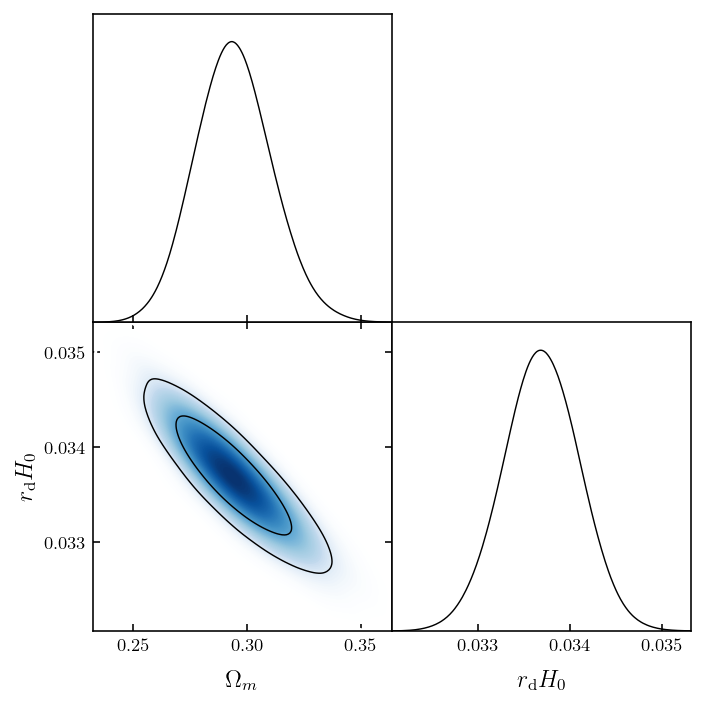

In [230]:
names = ['rdH0','omegam']    # put parameters here
labels =  ['r_{\\rm{d}}H_0','\Omega_m']    # label parameters here
MCsamples = MCSamples(samples=samples,names = names, labels = labels)
g = plots.getSinglePlotter(width_inch=5, ratio=1)
g.triangle_plot(MCsamples, ['omegam','rdH0'] , shaded=True)
g.export(os.path.join(r'figures',r'BAO_rdH0_Om.pdf'))

# CMB theta:
# This has three parameters: z_re, rsH0, Om

In [21]:
# MCMC to CMB theta alone

ndim, nwalkers, nstep = 3, 32, 6000  # settings for emcee
CMB_means = np.loadtxt('CMB_theta/CMB_theta_means.txt') # z_re, theta (R optional)
CMB_Cov = np.loadtxt('CMB_theta/CMB_theta_Cov.txt')
CMB_invC = np.linalg.inv(CMB_Cov)

# set the path/file to save the chain:
save_chain_file = 'CMB_theta/chains/CMB_walkers'+str(nwalkers)+'_step'+str(nstep)+'.csv'

    
# MCMC 
pos = [[1089*(1+0.001*np.random.randn()),
        0.03307*(1+0.01*np.random.randn()),0.3*(1+0.01*np.random.randn())] for i in range(nwalkers)]

sampler_CMB=emcee.EnsembleSampler(nwalkers, ndim, LIKE.lnprob_CMB, args=(CMB_means,CMB_invC))
sampler_CMB.run_mcmc(pos, nstep, progress=True,);
samples_CMB = sampler_CMB.chain[:, :, :].reshape((-1, ndim))   #filter out first XXX rows

np.savetxt(save_chain_file, samples_CMB, delimiter=',')

100%|██████████| 6000/6000 [03:52<00:00, 25.81it/s]


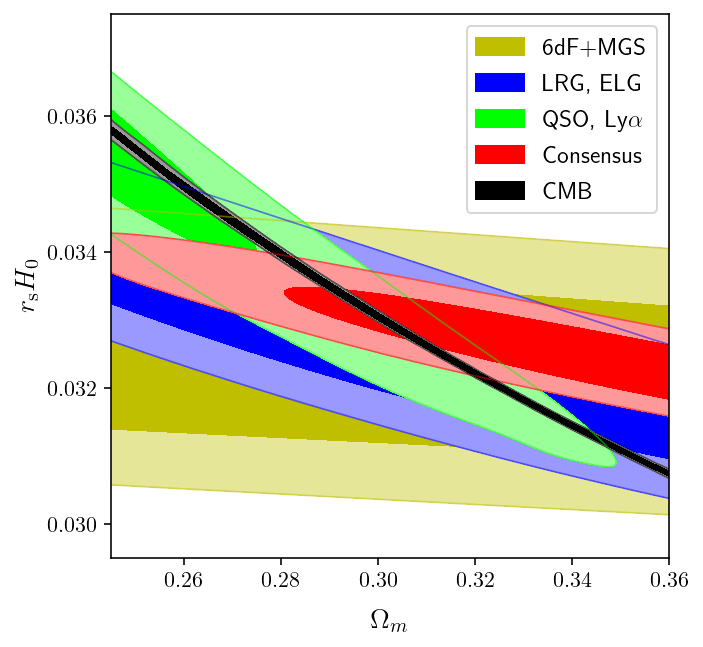

In [841]:
g = plots.getSinglePlotter(width_inch=5, ratio=1)
datasets = ['6df_MGS','DR16_LRG_ELG','qsarauto_lyaxqsar','DR12_consensus']
for bao_dataset,color in zip(datasets,['y','b','lime','r']):
    if bao_dataset=='DR16_LRG_ELG':
        load_chain_file = 'chains/BAO_only/'+bao_dataset+'_walkers64_step4000.csv'
    else:
        load_chain_file = 'chains/BAO_only/'+bao_dataset+'_walkers64_step2000.csv'
    samples = np.loadtxt(load_chain_file,delimiter=",")
    names = [r'rdH0', 'omegam']    # put parameters here
    labels =  [r'$r_{\rm{d}}H_0$',r'$\Omega_m$']    # label parameters here
    MCsamples = MCSamples(samples=samples,names = names, labels = labels,
                          ignore_rows=500,ranges={'omegam':[0.001,0.99]})
    p = MCsamples.getParams() 
    MCsamples.addDerived(p.rdH0-5.9707175E-4, name='rsH0', label=r'r_{\rm{s}}H_0')
    g.add_2d_contours(MCsamples, 'omegam', 'rsH0',color=color,filled=True)

    
load_chain_file = 'CMB_theta/chains/CMB_walkers32_step6000.csv'
samples = np.loadtxt(load_chain_file,delimiter=",")
names = ['zstar','rsH0', 'omegam']    # put parameters here
labels =  [r'z_*',r'r_{\rm{s}}H_0',r'\Omega_m']    # label parameters here
MCsamples = MCSamples(samples=samples,names = names, labels = labels,
                          ignore_rows=3000,ranges={'omegam':[0.01,0.99]})
g.add_2d_contours(MCsamples, 'omegam', 'rsH0',filled=True,color='k')
    
Pnames=getdist.paramnames.ParamList(names=names, labels=labels)
g.set_xlabel(Pnames.names[2]); g.set_ylabel(Pnames.names[1])
    

g.set_axes(lims=[0.245, 0.36, 0.0295, 0.0375])   # axis limits
g.add_legend(['6dF+MGS','LRG, ELG',r'QSO, Ly$\alpha$','Consensus','CMB'])
g.export(os.path.join(r'figures',r'Compare_rsH0_Om.pdf'))

# Combined analysis:

In [ ]:
# load SN data
pantheon_path='Pantheon_data/lcparam_full_long_zhel.txt'
pantheon0 = pd.read_csv(pantheon_path, sep=" ", header=0)
pantheon = pantheon0[['name','zcmb','mb','dmb']]
pantheon = pantheon.sort_values(by='zcmb')    # sort SNIa in a z-ascending order for the new algorithm
pantheon = pantheon.reset_index()             # have to reset the index, otherwise the index is not sorted
Npan = len(pantheon.zcmb)   # number of all SN
pan_sys=np.loadtxt("Pantheon_data/sys_full_long_sort.txt")   # systematic errors
C_pan = pan_sys+np.diag(pantheon.dmb**2) # including systematic errors
invC_pan = np.linalg.inv(C_pan)

# load BAO data
#BAO_data_path='BAO_data/'
#BAO_datasets = ['6df','DR7_MGS','DR12_consensus','DR14_qsar','DR14_lya_qsar','DR16_LRG_ELG']

# load CMB theta
CMB_means = np.loadtxt('CMB_theta/CMB_theta_means.txt')
CMB_Cov = np.loadtxt('CMB_theta/CMB_theta_Cov.txt')
CMB_invC = np.linalg.inv(CMB_Cov)

In [245]:
# Define the combined likelihoods

def lnprior_combined(theta): # keep the order of theta to be zstar, rsH0, MH0, Om, h, DeltarH0, m_v1
    if len(theta)==6:
        if 1070<theta[0]<1120 and 0.01<theta[1]<0.1 and 17<theta[2]<30 and 0.01<theta[3]<0.99 and 0.55<theta[4]<0.88 and 5.E-4<theta[5]<7.E-4:
            return 0.0
    if len(theta)==7:
        if 1070<theta[0]<1120 and 0.01<theta[1]<0.1 and 17<theta[2]<30 and 0.01<theta[3]<0.99 and 0.55<theta[4]<0.88 and 5.E-4<theta[5]<7.E-4 and 0.0002<theta[5]<1.0:
            return 0.0
    return -np.inf

def lnprob_stds(theta,SN_input,BAO_input,CMB_input,CC_input):
    use_SN, SN_data, invC = SN_input   # use fast SN likelihood by default
    BAO_data_path, BAO_datasets = BAO_input
    CMB_means, CMB_invC = CMB_input
    use_CC,CC_path = CC_input
    if len(theta)==6:
        zstar_fit, rsH0_fit, MH0_fit, Om_fit, h_fit, DeltarH0_fit = theta
        m_v1_fit=0.0
        #rdH0_derived = rsH0_fit+BG.Delta_rH0(zstar_fit,29.98,Om_fit,h_fit) 
        # Deltaz is set to be 29.98, need further consideration
        rdH0_derived = rsH0_fit+DeltarH0_fit # used a prior on Deltar instead
        theta_SN = [MH0_fit, Om_fit, h_fit]
        theta_BAO = [rdH0_derived, Om_fit, h_fit]
        theta_CMB = [zstar_fit, rsH0_fit, Om_fit, h_fit]
    if len(theta)==7:
        zstar_fit, rsH0_fit, MH0_fit, Om_fit, h_fit, DeltarH0_fit, m_v1_fit = theta
        #rdH0_derived = rsH0_fit+BG.Delta_rH0(zstar_fit,29.98,Om_fit,h_fit,m_v1_fit)
        rdH0_derived = rsH0_fit+DeltarH0_fit # used a prior on DeltarH0 instead
        theta_SN = [MH0_fit, Om_fit, h_fit, m_v1_fit]
        theta_BAO = [rdH0_derived, Om_fit, h_fit, m_v1_fit]
        theta_CMB = [zstar_fit, rsH0_fit, Om_fit, h_fit, m_v1_fit]
        
    lp = lnprior_combined(theta)
    if not np.isfinite(lp):
        return -np.inf
    if use_SN:
        lp += LIKE.lnlike_SN_fast(theta_SN, SN_data, invC)
    lp += LIKE.lnlike_BAO(theta_BAO, BAO_data_path, BAO_datasets)
    lp += LIKE.lnlike_CMB(theta_CMB, CMB_means, CMB_invC)
    lp += -0.5*(DeltarH0_fit-5.9707175E-4)**2/(1E-5)**2  # some model insensitive prior on Deltar 
    
    if use_CC==True:
        chronometers = np.loadtxt(CC_path)
        Hz = BG.Hz(chronometers[:,0], h_fit*100, Om_fit)
        lp += -0.5*(np.sum((Hz-chronometers[:,1])**2/chronometers[:,2]**2))
        
    return lp
    

In [587]:
# This is the define treatment
# Define the default combined likelihoods 

def lnprob_stds_default(theta,SN_input,BAO_input,CMB_input,CC_input):
    use_SN, SN_data, invC = SN_input   # use fast SN likelihood by default
    BAO_data_path, BAO_datasets = BAO_input
    CMB_means, CMB_invC, Deltazrec_obs, dDeltazrec_obs = CMB_input
    use_CC,CC_path = CC_input
    zstar_fit, rsH0_fit, MH0_fit, Om_fit, h_fit, Deltazrec, omegabh2 = theta
    m_v1_fit=0.0  # normal hierachy, lowest mass =0 
    
    lp = 0.0
    # priors: keep the order of theta to be zstar, rsH0, MH0, Om, h, Deltazrec, omegabh2
    if not (1070<theta[0]<1120 and 0.01<theta[1]<0.1 and 17<theta[2]<30 and \
              0.01<theta[3]<0.99 and 0.55<theta[4]<0.88 and \
              20<theta[5]<40 and 0.01<theta[6]<0.04):
        return -np.inf
    rdH0_derived = rsH0_fit+BG.Delta_rH0(zstar_fit,Deltazrec,Om_fit,h_fit,omegabh2) 
    lp += -0.5*(Deltazrec-Deltazrec_obs)**2/(dDeltazrec_obs)**2  
    lp += -0.5*(omegabh2-0.0222)**2/0.0005**2
    
    theta_SN = [MH0_fit, Om_fit, h_fit]
    theta_BAO = [rdH0_derived, Om_fit, h_fit]
    theta_CMB = [zstar_fit, rsH0_fit, Om_fit, h_fit]
    
    if use_SN:
        lp += LIKE.lnlike_SN_fast(theta_SN, SN_data, invC)
    lp += LIKE.lnlike_BAO(theta_BAO, BAO_data_path, BAO_datasets)
    lp += LIKE.lnlike_CMB(theta_CMB, CMB_means, CMB_invC)
    
    if use_CC==True:
        chronometers = np.loadtxt(CC_path)
        Hz = BG.Hz(chronometers[:,0], h_fit*100, Om_fit)
        lp += -0.5*(np.sum((Hz-chronometers[:,1])**2/chronometers[:,2]**2))
        
    return lp
    

# Combined MCMC

# Use default treatment on the difference of sound horizon:

In [588]:
ndim, nwalkers, nstep = 7, 64, 3000  # settings for emcee
# set the path/file to save the chain:

pantheon_path='Pantheon_data/lcparam_full_long_zhel.txt'
pantheon0 = pd.read_csv(pantheon_path, sep=" ", header=0)
pantheon = pantheon0[['name','zcmb','mb','dmb']]
pantheon = pantheon.sort_values(by='zcmb')    # sort SNIa in a z-ascending order for the new algorithm
pantheon = pantheon.reset_index()             # have to reset the index, otherwise the index is not sorted
pan_sys=np.loadtxt("Pantheon_data/sys_full_long_sort.txt")   # systematic errors
C_pan = pan_sys+np.diag(pantheon.dmb**2) # including systematic errors
invC_pan = np.linalg.inv(C_pan)
SN_input=[True,pantheon,invC_pan]

# choose from '6df','DR7_MGS','DR12_consensus','DR16_LRG_ELG','DR14_qsar','DR14_lya_qsar'
BAO_input= ['BAO_data/',['6df','DR7_MGS','DR12_consensus','DR16_LRG_ELG','DR14_qsar','DR14_lya_qsar']]
SAVEFILE_prefix='ALL_UCstds' # specify

# choose from 'CMB' and 'ACT' for prefix:
CMB_prefix='CMB' # specify
save_chain_file = 'chains/Default/'+CMB_prefix+'theta_BAO/'+SAVEFILE_prefix+'_'+str(nwalkers)+'_step'+str(nstep)+'.csv'
CMB_means = np.loadtxt('CMB_theta/'+CMB_prefix+'_theta_means.txt') # z_re, theta (R optional)
CMB_Cov = np.loadtxt('CMB_theta/'+CMB_prefix+'_theta_Cov.txt')
CMB_invC = np.linalg.inv(CMB_Cov)
if CMB_prefix=='CMB': #this is for Planck
    theta_cmb=3.0025609E+01
    dtheta_cmb=5.4452421E-01
elif CMB_prefix=='CMB': # this is for ACT:
    theta_cmb=2.9952195E+01
    dtheta_cmb=7.5056623E-01
else:
    print('Invilid CMB prefix.')

CMB_input= [CMB_means,CMB_invC,theta_cmb,dtheta_cmb]

# use CC or not
CC_input=[False,'./CC_data/CC_with_ExtraError.txt'] #### 

# MCMC:

# initial position
pos = [[1089.0*(1+0.0002*np.random.randn()),   # z_rec
        0.033*(1+0.0005*np.random.randn()),    # rsH0
        23.809306*(1+0.0003*np.random.randn()),   # MH0
        0.3*(1+0.0003*np.random.randn()),         # Omegam
        0.7*(1+0.002*np.random.randn()),          # h
        30*(1+0.002*np.random.randn()),           # Deltaz_decoupling
        0.0222*(1+0.002*np.random.randn())] for i in range(nwalkers)]       # omegabh2

sampler_combined=emcee.EnsembleSampler(nwalkers, ndim, lnprob_stds_default, 
                                       args=(SN_input,BAO_input,CMB_input,CC_input))
sampler_combined.run_mcmc(pos, nstep, progress=True,);
samples_combined = sampler_combined.chain[:, :, :].reshape((-1, ndim))   #filter out first XXX rows
np.savetxt(save_chain_file, samples_combined, delimiter=',')

100%|██████████| 3000/3000 [1:03:00<00:00,  1.26s/it]


In [ ]:
load_chain_file = save_chain_file  # choose file to load
samples = np.loadtxt(load_chain_file,delimiter=",")

# Saving Median and upper and lower limits
zstar_medianstat,rsH0_medianstat,MH0_medianstat,Om_medianstat,h_medianstat,\
            Deltazrec_mediansta, omegabh2_medianstat = map(lambda v: ((v[1], \
            v[2]-v[1], v[1]-v[0])), zip(*np.percentile(samples, [16, 50, 84], axis=0))) # median + upper - lower
    
# Saving means and uncertainty
zstar_mean,rsH0_mean,MH0_mean,Om_mean,h_mean,Deltazrec_mean,omegabh2_mean = np.mean(samples,axis=0)
zstar_std,rsH0_std,MH0_std,Om_std,h_std,Deltazrec_mean,omegabh2_mean = np.std(samples,axis=0)
    
print('Median+upper-lower:')
# display median + upper -lower of rdH0
for MEDIAN, PARAM in zip([Om_medianstat,h_medianstat], ['\Omega_{\mathrm{m}}','h']):
    txt = "{3} = {{{0: 2.4f}}}^{{+{1: .4f}}}_{{-{2: .4f}}}"
    txt = txt.format(MEDIAN[0], MEDIAN[1], MEDIAN[2], PARAM)
    display(Math(txt))

# display mean+-uncertainty
print('Mean+-uncertainty:')
for MEAN, STD, PARAM in zip([Om_mean,h_mean], [Om_std,h_std], ['\Omega_{\mathrm{m}}','h']):
    txt = "{2} = {0: 2.3f}\pm{1: .3f}"
    txt = txt.format(MEAN, STD, PARAM)
    display(Math(txt))

In [ ]:
load_chain_file = save_chain_file # choose file to load
samples = np.loadtxt(load_chain_file,delimiter=",")
names = ['zstar','rsH0', 'MH0','omegam','h','Deltazrec','omegabh2']    # put parameters here
labels =  [r'z_*',r'r_{\rm{s}}H_0',r'\mathcal{M}',r'\Omega_m',r'h',r'\Delta z_{dec}','\Omega_b h^2']
MCsamples = MCSamples(samples=samples,names = names, labels = labels,ranges={'h':(0.55, 0.88)},
                      label='Uncalibrated Cosmic Standards')
p = MCsamples.getParams() 
MCsamples.addDerived(p.h*100, name='H0', label=r'$H_0$',range=[55,88])
Delta_rH0s=[]
for xa,xb,xc,xd,xe in zip(p.zstar,p.Deltazrec,p.omegam,p.h,p.omegabh2):
     Delta_rH0s.append(BG.Delta_rH0(xa,xb,xc,xd,xe))  
MCsamples.addDerived(np.array(Delta_rH0s),name='DeltarsH0', label=r'$\Delta r_sH_0$')
g = plots.getSinglePlotter(width_inch=8, ratio=1)
g.triangle_plot(MCsamples, ['rsH0', 'MH0','omegam'] , shaded=True)
g.export(os.path.join(r'figures',r'Combined.pdf'))

In [ ]:
# Compare to the Planck traditional constraint and CV SN local measurement

PathExtra='/Users/weikanglin/Documents/Documents NCSU/Projects/3STDs/chains_new/'
g = plots.getSinglePlotter(width_inch=5, ratio=0.8)
g.settings.alpha_filled_add=0.5
#g.add_y_bands(0.298, 0.022, alpha1=0.2,alpha2=0.2,color='grey',zorder=1)
g.add_x_bands(74.03, 1.42, alpha1=0.4,alpha2=0.2, color='yellow',zorder=1) 
#g.add_x_bands(69.6, 1.88, alpha1=0.3,alpha2=0.23, color='pink',zorder=1) 
g.plot_2d([MCsamples], 'H0', 'omegam',filled=True,zorder=2)
g.add_2d_contours(PathExtra+'base_plikHM_TTTEEE_lowl_lowE', 'H0', 'omegam',
                  filled=True, color='k');

H0_range=np.arange(55,88,0.1)
Om_up1=(0.298+0.010236796512)+(H0_range-70)*0.00014
Om_low1=(0.298-0.010236796512)+(H0_range-70)*0.00014
plt.plot(H0_range,Om_up1,color='red')
plt.plot(H0_range,Om_low1,color='red')

g.set_axes(lims=[60, 80, 0.265, 0.345])
g.export(os.path.join(r'figures',r'Compare_UCstds.pdf'))

# Run CMB theta + individual BAO:

In [240]:
ndim, nwalkers, nstep = 7, 64, 10000  # settings for emcee

# SN input:
pantheon_path='Pantheon_data/lcparam_full_long_zhel.txt'
pantheon0 = pd.read_csv(pantheon_path, sep=" ", header=0)
pantheon = pantheon0[['name','zcmb','mb','dmb']]
pantheon = pantheon.sort_values(by='zcmb')    # sort SNIa in a z-ascending order for the new algorithm
pantheon = pantheon.reset_index()             # have to reset the index, otherwise the index is not sorted
Npan = len(pantheon.zcmb)   # number of all SN
pan_sys=np.loadtxt("Pantheon_data/sys_full_long_sort.txt")   # systematic errors
C_pan = pan_sys+np.diag(pantheon.dmb**2) # including systematic errors
invC_pan = np.linalg.inv(C_pan)
SN_input=[False,pantheon,invC_pan]

# BAO input:
BAO_input= ['BAO_data/',['6df','DR7_MGS','DR12_consensus','DR14_qsar','DR14_lya_qsar','DR16_LRG_ELG']]

# CMB theta input
CMB_prefix='CMB'
save_chain_file = 'chains/Default/'+CMB_prefix+'theta_BAO/'+SAVEFILE_prefix+'_'+str(nwalkers)+'_step'+str(nstep)+'.csv'
CMB_means = np.loadtxt('CMB_theta/'+CMB_prefix+'_theta_means.txt') # z_re, theta (R optional)
CMB_Cov = np.loadtxt('CMB_theta/'+CMB_prefix+'_theta_Cov.txt')
CMB_invC = np.linalg.inv(CMB_Cov)
if CMB_prefix=='CMB': #this is for Planck
    theta_cmb=3.0025609E+01
    dtheta_cmb=5.4452421E-01
elif CMB_prefix=='ACT': # this is for ACT:
    theta_cmb=2.9952195E+01
    dtheta_cmb=7.5056623E-01
else:
    print('Invilid CMB prefix.')
    
## CC input
CC_input=[False,'./CC_data/CC_with_ExtraError.txt']

# MCMC 
for BAO_name in ['DR16_LRG_ELG']:
    BAO_input = ['BAO_data/',[BAO_name]]
    save_chain_file = 'chains/Default/'+CMB_prefix+'theta_BAO/'+BAO_name+'_'+str(nwalkers)+'_step'+str(nstep)+'.csv'
    pos = [[1089.0*(1+0.0002*np.random.randn()),   # z_rec
        0.033*(1+0.0005*np.random.randn()),    # rsH0
        23.809306*(1+0.0003*np.random.randn()),   # MH0
        0.3*(1+0.001*np.random.randn()),         # Omegam
        0.7*(1+0.01*np.random.randn()),          # h
        30*(1+0.002*np.random.randn()),           # Deltaz_decoupling 3
        0.0222*(1+0.002*np.random.randn())] for i in range(nwalkers)]       # omegabh2

    sampler_combined=emcee.EnsembleSampler(nwalkers, ndim, lnprob_stds_default, 
                                       args=(SN_input,BAO_input,CMB_input,CC_input))
    sampler_combined.run_mcmc(pos, nstep, progress=True,);
    samples_combined = sampler_combined.chain[:, :, :].reshape((-1, ndim))   #filter out first XXX rows
    np.savetxt(save_chain_file, samples_combined, delimiter=',')

100%|██████████| 10000/10000 [19:07<00:00,  8.71it/s]


In [280]:
nwalkers=64
names = ['zstar','rsH0', 'MH0','omegam','h','Deltazrec','omegabh2']    # put parameters here
labels =  [r'z_*',r'r_{\rm{s}}H_0',r'\mathcal{M}',r'\Omega_m',r'h',r'\Delta z_{dec}','\Omega_b h^2']
Om_means={'Planck':[],'ACT+WMAP':[]}
Om_stds={'Planck':[],'ACT+WMAP':[]}
for BAO_name in ['6df+DR7_MGS','DR16_LRG_ELG','DR12_consensus',
                 'All_BAO_butconsensus_SN','All_BAO_SN']:
    print(r'CMB+'+BAO_name)
    for prefix, path_name in zip(['Planck','ACT+WMAP'],['CMB','ACT']):
        if BAO_name=='6df+DR7_MGS' or BAO_name=='DR12_consensus' or \
                         BAO_name=='DR16_LRG_ELG' or BAO_name=='6df+MGS+LRG_ELG':
            nstep=10000
        else:
            nstep=3000
        load_chain_file = 'chains/Default/'+path_name+'theta_BAO/'+ \
                 BAO_name+'_'+str(nwalkers)+'_step'+str(nstep)+'.csv'
        samples = np.loadtxt(load_chain_file,delimiter=",")
        MCsamples = MCSamples(samples=samples,names = names, labels = labels,ranges={'h':(0.55, 0.88)},
                      label='Uncalibrated Cosmic Standards',ignore_rows=2000)
        txt=prefix+': '+str(round(MCsamples.getMargeStats().parWithName('omegam').mean,4))+ \
                '\pm'+str(round(MCsamples.std('omegam'),4))
        display(Math(txt))
        Om_means[prefix].append(MCsamples.getMargeStats().parWithName('omegam').mean)
        Om_stds[prefix].append(MCsamples.std('omegam'))
        

CMB+6df+DR7_MGS


<IPython.core.display.Math object>

<IPython.core.display.Math object>

CMB+DR16_LRG_ELG


<IPython.core.display.Math object>

<IPython.core.display.Math object>

CMB+DR12_consensus


<IPython.core.display.Math object>

<IPython.core.display.Math object>

CMB+All_BAO_butconsensus_SN


<IPython.core.display.Math object>

<IPython.core.display.Math object>

CMB+All_BAO_SN


<IPython.core.display.Math object>

<IPython.core.display.Math object>

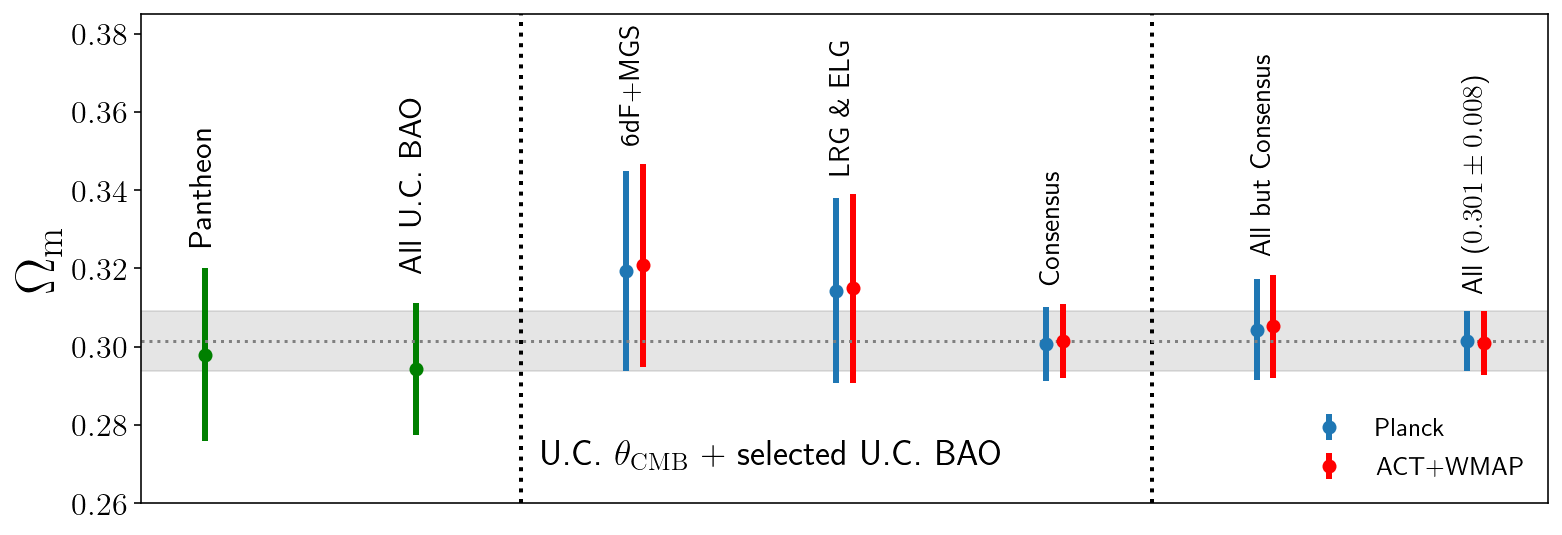

In [290]:
N_bao = len(Om_means['Planck'])
handles={'Planck':[],'ACT+WMAP':[]}
fig,ax = plt.subplots(figsize=((N_bao+2)*1.8,4.5))
plt.errorbar(-2,0.298,0.022,fmt='og',linewidth=3)
plt.errorbar(-1,0.29424,0.01690,fmt='og',linewidth=3) # All BAO
for prefix, offset, fmt,ls,handle_index in zip(['Planck','ACT+WMAP'],[0,0.08],['o','or'],['-',':'],[0,1]):
    handles[prefix]=plt.errorbar(np.arange(N_bao)+offset,Om_means[prefix],
                            Om_stds[prefix],fmt=fmt,linewidth=3,label=prefix)
plt.axvline(x=N_bao-2.5,linestyle=':',color='k',linewidth=2)
plt.axvline(x=-.5,linestyle=':',color='k',linewidth=2)
plt.ylabel(r'$\Omega_{\rm{m}}$',fontsize=28)
plt.yticks(fontsize=16)
plt.axhspan(Om_means['Planck'][-1]-Om_stds['Planck'][-1],
                  Om_means['Planck'][-1]+Om_stds['Planck'][-1],color='gray',alpha=0.2)
plt.axhline(y=Om_means['Planck'][-1],ls=':',color='grey')
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.text(-2.08, 0.298+0.022+0.007,'Pantheon',fontsize=16,rotation=90)
plt.text(-1.08, 0.29582+0.01729+0.007,'All U.C. BAO',fontsize=16,rotation=90)
plt.text(-.4, 0.27,r'U.C. $\theta_{\rm{CMB}}$ + selected U.C. BAO',fontsize=18)

for bao, i in zip(['6dF+MGS',r'LRG \& ELG','Consensus',
                   'All but Consensus','All'+r' ($'+str(round(Om_means['Planck'][-1],3))
         +'\pm'+str(round(Om_stds['Planck'][-1],3))+'$)'],np.arange(N_bao)):
    plt.text(i-0.03, max(Om_means['Planck'][i]+Om_stds['Planck'][i],
                        Om_means['ACT+WMAP'][i]+Om_stds['ACT+WMAP'][i])+0.006,bao,fontsize=14,rotation=90)

plt.legend([handles['Planck'],handles['ACT+WMAP']],['Planck','ACT+WMAP'],
           loc='lower right',fontsize=13,frameon=False)
plt.ylim(0.26,0.385)
plt.savefig('figures/Constraints_Om.pdf', bbox_inches='tight')

# Use secondary treatment:

In [ ]:
ndim, nwalkers, nstep = 6, 64, 1000  # settings for emcee
# set the path/file to save the chain:
save_chain_file = 'chains/UCstds_'+str(nwalkers)+'_step'+str(nstep)+'.csv'

SN_input=[pantheon,invC_pan]
BAO_input= ['BAO_data/',['6df','DR7_MGS','DR12_consensus','DR14_qsar','DR14_lya_qsar','DR16_LRG_ELG']]
CMB_input= [CMB_means,CMB_invC]
CC_input=[False,'../3STDs/cosmic_chronometers_data/CC_with_ExtraError.txt']
# MCMC 
pos = [[1089.0*(1+0.0002*np.random.randn()),
        0.033*(1+0.0005*np.random.randn()),
        23.809306*(1+0.0003*np.random.randn()),
        0.3*(1+0.0003*np.random.randn()),
        0.7*(1+0.002*np.random.randn()),
        5.9707175E-4*(1+0.002*np.random.randn())] for i in range(nwalkers)]

sampler_combined=emcee.EnsembleSampler(nwalkers, ndim, lnprob_stds, args=(SN_input,BAO_input,CMB_input,CC_input))
sampler_combined.run_mcmc(pos, nstep, progress=True,);

samples_combined = sampler_combined.chain[:, 100:, :].reshape((-1, ndim))   #filter out first XXX rows

np.savetxt(save_chain_file, samples_combined, delimiter=',')

# Calculate Summary Statistics

In [ ]:
load_chain_file = save_chain_file  # choose file to load
samples = np.loadtxt(load_chain_file,delimiter=",")

# Saving Median and upper and lower limits
zstar_medianstat,rsH0_medianstat,MH0_medianstat,Om_medianstat,h_medianstat,Deltar_medianstat = map(lambda v: ((v[1], 
            v[2]-v[1], v[1]-v[0])), zip(*np.percentile(samples, [16, 50, 84], axis=0))) # median + upper - lower
    
# Saving means and uncertainty
zstar_mean,rsH0_mean,MH0_mean,Om_mean,h_mean,Deltar_mean = np.mean(samples,axis=0)
zstar_std,rsH0_std,MH0_std,Om_std,h_std,Deltar_std = np.std(samples,axis=0)
    
print('Median+upper-lower:')
# display median + upper -lower of rdH0
for MEDIAN, PARAM in zip([Om_medianstat,h_medianstat], ['\Omega_{\mathrm{m}}','h']):
    txt = "{3} = {{{0: 2.4f}}}^{{+{1: .4f}}}_{{-{2: .4f}}}"
    txt = txt.format(MEDIAN[0], MEDIAN[1], MEDIAN[2], PARAM)
    display(Math(txt))

# display mean+-uncertainty
print('Mean+-uncertainty:')
for MEAN, STD, PARAM in zip([Om_mean,h_mean], [Om_std,h_std], ['\Omega_{\mathrm{m}}','h']):
    txt = "{2} = {0: 2.3f}\pm{1: .3f}"
    txt = txt.format(MEAN, STD, PARAM)
    display(Math(txt))

In [ ]:
load_chain_file = save_chain_file # choose file to load
samples = np.loadtxt(load_chain_file,delimiter=",")
names = ['zstar','rsH0', 'MH0','omegam','h','DeltarH0']    # put parameters here
labels =  [r'$z_*$',r'$r_{\rm{s}}H_0$',r'$\mathcal{M}$',r'$\Omega_m$',r'$h$',r'$\Delta r_sH_0$']    # label parameters here
MCsamples = MCSamples(samples=samples,names = names, labels = labels,ranges={'h':(0.55, 0.88)},
                      label='Uncalibrated Cosmic Standards')
p = MCsamples.getParams() 
MCsamples.addDerived(p.h*100, name='H0', label=r'$H_0$',range=[55,88])
g = plots.getSinglePlotter(width_inch=8, ratio=1)
g.triangle_plot(MCsamples, ['rsH0', 'MH0','omegam'] , shaded=True)
g.export(os.path.join(r'figures',r'Combined.pdf'))

In [ ]:
PathExtra='/Users/weikanglin/Documents/Documents NCSU/Projects/3STDs/chains_new/'
g = plots.getSinglePlotter(width_inch=5, ratio=0.8)
g.settings.alpha_filled_add=0.5
#g.add_y_bands(0.298, 0.022, alpha1=0.2,alpha2=0.2,color='grey',zorder=1)
g.add_x_bands(74.03, 1.42, alpha1=0.4,alpha2=0.2, color='yellow',zorder=1) 
#g.add_x_bands(69.6, 1.88, alpha1=0.3,alpha2=0.23, color='pink',zorder=1) 
g.plot_2d([MCsamples], 'H0', 'omegam',filled=True,zorder=2)
g.add_2d_contours(PathExtra+'base_plikHM_TTTEEE_lowl_lowE', 'H0', 'omegam',
                  filled=True, color='k');

H0_range=np.arange(55,88,0.1)
Om_up1=(0.300322+0.010236796512)+(H0_range-70.579829)*0.0002
Om_low1=(0.300322-0.010236796512)+(H0_range-70.579829)*0.0002
plt.plot(H0_range,Om_up1,color='red')
plt.plot(H0_range,Om_low1,color='red')

g.set_axes(lims=[60, 80, 0.265, 0.345])
g.export(os.path.join(r'figures',r'Compare_UCstds.pdf'))

In [ ]:
print(MCsamples.PCA(['omegam','H0'],param_map=['N','N']))

In [ ]:
PC1_mean=(1.014188*0.70833402)**(-1/5.172426)*0.299618
PC1_std=PC1_mean*(0.170617/1.014188)/5.172426
print(PC1_mean,PC1_std)

# Belows are some preliminary results for LSS

In [ ]:
tempdir='/Users/weikanglin/Documents/Documents NCSU/Projects/3STDs/chains_LSS/'
g = plots.getSinglePlotter(chain_dir=tempdir,width_inch=7, ratio=0.8)
g.settings.alpha_filled_add=0.6
samples_DES = loadMCSamples(tempdir, settings={'ignore_rows':0.3}); 
g.plot_2d([samples_DES,MCsamples], 'H0', 'omegam',filled=True)

# preliminary:
#g.add_2d_covariance(np.array([72.4626984 ,  0.29842372]), 
#                    np.array([[4.68442296e+01, 1.10692999e-03],[1.10692999e-03, 6.61706597e-05]]),
#                    filled=True, color='g',alpha=0.75)

g.add_legend(['DES','Uncalibrated Cosmic Standards', 'Preliminary Joint'])
g.set_axes(lims=[55, 85, 0.24, 0.36])


g.export(os.path.join(r'figures',r'Combined_h_Om_new.pdf'))

In [ ]:
# Saving Median and upper and lower limits
# Saving means and uncertainty

load_chain_file = save_chain_file # choose file to load
samples_all_rulers = np.loadtxt(load_chain_file,delimiter=",")
names = ['zstar','rsH0', 'MH0','omegam','h']    # put parameters here
labels =  [r'$z_*$',r'$r_{\rm{s}}H_0$',r'$MH_0$',r'$\Omega_m$',r'$h$']    # label parameters here
MCsamples_UCrulers = MCSamples(samples=samples,names = names, labels = labels,ranges={'h':(None, 2)},
                      label='Uncalibrated Standard Rulers')
p = MCsamples_UCrulers.getParams() 
MCsamples_UCrulers.addDerived(p.h*100, name='H0', label=r'$H_0$')

MEANS = np.mean(samples,axis=0)
ERRORS = np.std(samples,axis=0)
    
print('Median+upper-lower:')

# display mean+-uncertainty
print('Mean+-uncertainty:')
for MEAN, STD, PARAM in zip(MEANS, ERRORS, [r'z_*',r'r_{\rm{s}}H_0',
                                            r'M-5\log_{10}(10{\rm{pc}}\times H_0)',r'\Omega_m',r'h']):
    txt = "{2} = {0: 2.4f}\pm{1: .4f}"
    txt = txt.format(MEAN, STD, PARAM)
    display(Math(txt))

In [ ]:
CMB_means = np.loadtxt('CMB_theta/CMB_theta_means.txt')
CMB_Cov = np.loadtxt('CMB_theta/CMB_theta_Cov.txt')
CMB_invC = np.linalg.inv(CMB_Cov)

SN_input=[pantheon,invC_pan]
BAO_input= ['BAO_data/',['6df','DR7_MGS','DR12_consensus','DR14_qsar','DR14_lya_qsar']]
CMB_input= [CMB_means,CMB_invC]
lnprob_stds([1089.9515,0.03243,23.809306,0.3,0.70],SN_input,BAO_input,CMB_input)

# Compare All+CC vs approximation:

In [388]:
# define CC likelihood:
chronometers = np.loadtxt('./CC_data/CC_with_ExtraError.txt')
def CC_like(h_fit,Om_fit,chronometers):
    Hz = BG.Hz(chronometers[:,0], h_fit*100, Om_fit)
    return np.exp(-0.5*(np.sum((Hz-chronometers[:,1])**2/chronometers[:,2]**2)))

# define CC+SN likelihood:
def lnprob_CC_SN(theta,use_SN,CC_input):
    use_CC, chronometers = CC_input
    Om_fit, H0_fit= theta
    
    lp = 0.0
    if not (0.01<Om_fit<0.99 and 55<H0_fit<85):
        return -np.inf
    
    if use_SN:
        lp += -0.5*(Om_fit-0.298)**2/0.022**2
    
    if use_CC==True:
        Hz = BG.Hz(chronometers[:,0], H0_fit, Om_fit)
        lp += -0.5*(np.sum((Hz-chronometers[:,1])**2/chronometers[:,2]**2))
        
    return lp


In [389]:
save_chain_file = 'chains/CC_SN/CC_SN.txt'
ndim, nwalkers, nstep = 2, 16, 3000  # settings for emcee
pos = [ [0.3*(1+0.001*np.random.randn()),         # Omegam
        70*(1+0.01*np.random.randn())] for i in range(nwalkers)]       # omegabh2
CC_input=[True,chronometers]
sampler_CC_SN=emcee.EnsembleSampler(nwalkers, ndim, lnprob_CC_SN, args=(True,CC_input))
sampler_CC_SN.run_mcmc(pos, nstep, progress=True,);
samples_CC_SN = sampler_CC_SN.chain[:, :, :].reshape((-1, ndim))   #filter out first XXX rows
np.savetxt(save_chain_file, samples_combined)

100%|██████████| 3000/3000 [00:04<00:00, 710.01it/s]


In [390]:
MCsamples_CC_SN = MCSamples(samples=samples_CC_SN,names = ['omegam','H0'], 
                        labels = [r'\Omega_{\rm{m}}',r'H_0'],ranges={'H0':(55, 85)})
print(MCsamples_CC_SN.getMargeStats())

Removed no burn in
Marginalized limits: 0.68; 0.95; 0.99

parameter   mean           sddev          lower1         upper1         limit1 lower2         upper2         limit2 lower3         upper3         limit3 
omegam      2.9970696E-01  2.1237246E-02  2.7869554E-01  3.2083862E-01  two    2.5810162E-01  3.4150500E-01  two    2.4607503E-01  3.5473787E-01  two     \Omega_{\rm{m}}
H0          6.9467137E+01  2.3819241E+00  6.7170308E+01  7.1887594E+01  two    6.4742344E+01  7.4146619E+01  two    6.3208889E+01  7.5620757E+01  two     H_0



Removed no burn in
Removed no burn in
Marginalized limits: 0.68; 0.95; 0.99

parameter   mean           sddev          lower1         upper1         limit1 lower2         upper2         limit2 lower3         upper3         limit3 
zstar       1.0899341E+03  2.9279911E-01  1.0896581E+03  1.0902205E+03  two    1.0893439E+03  1.0904872E+03  two    1.0889919E+03  1.0906530E+03  two     z_*
rsH0        3.2997880E-02  3.1618010E-04  3.2681697E-02  3.3303252E-02  two    3.2377077E-02  3.3633501E-02  two    3.2188507E-02  3.3831353E-02  two     r_{\rm{s}}H_0
MH0         2.3810708E+01  5.3161082E-03  2.3805434E+01  2.3815967E+01  two    2.3800070E+01  2.3820961E+01  two    2.3796767E+01  2.3824293E+01  two     \mathcal{M}
omegam      3.0120935E-01  7.2404573E-03  2.9422177E-01  3.0845978E-01  two    2.8702739E-01  3.1576244E-01  two    2.8270878E-01  3.2044596E-01  two     \Omega_m
h           6.9174300E-01  2.0961748E-02  6.7078717E-01  7.1233423E-01  two    6.5015193E-01  7.3273425E-01  two  

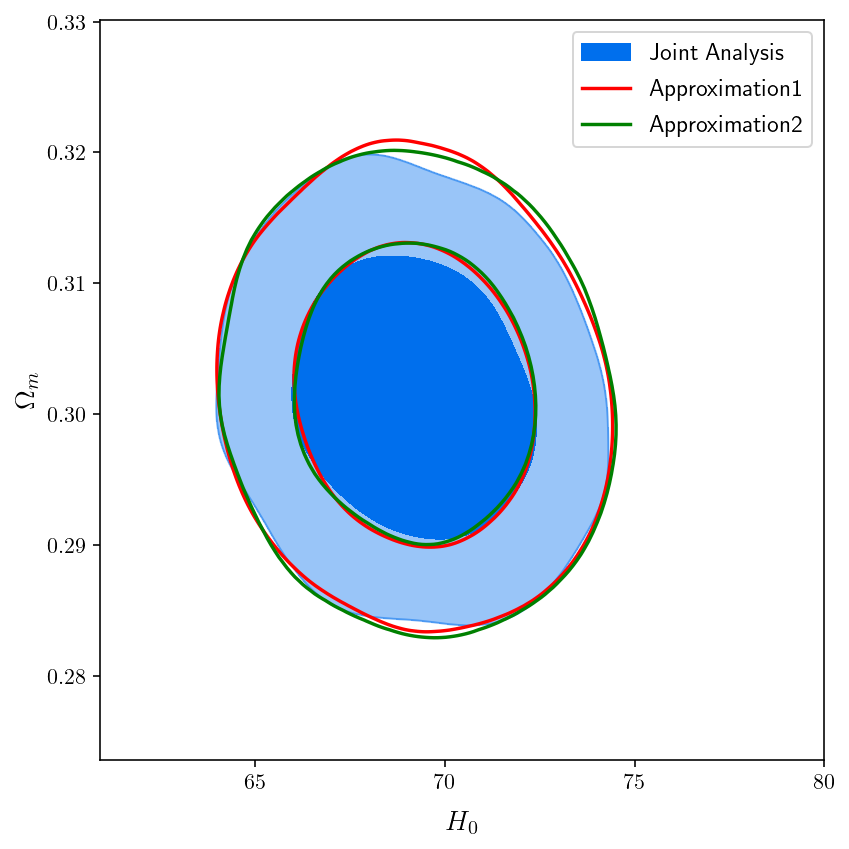

In [782]:
g = plots.getSinglePlotter(ratio=1)

#joint analysis
samples_load_All_BAO_SN_CC = np.loadtxt('./chains/Default/CMBtheta_BAO/AllwCC_64_step2000.csv',delimiter=",")
MCsamples_all = MCSamples(samples=samples_load_All_BAO_SN_CC,
                          names =['zstar','rsH0', 'MH0','omegam','h','Deltazrec','omegabh2'],ignore_rows=200,
                    labels =[r'z_*',r'r_{\rm{s}}H_0',r'\mathcal{M}',r'\Omega_m',r'h'],ranges={'h':(0.6, 0.8)})
p = MCsamples_all.getParams() 
MCsamples_all.addDerived(p.h*100, name='H0', label=r'$H_0$',range=[60,80])
g.plot_2d(MCsamples_all, 'H0', 'omegam',filled=True, color='b'); 


# approximation 1
names = ['zstar','rsH0', 'MH0','omegam','h','Deltazrec','omegabh2']    # put parameters here
labels =  [r'z_*',r'r_{\rm{s}}H_0',r'\mathcal{M}',r'\Omega_m',r'h',r'\Delta z_{dec}','\Omega_b h^2']
samples_load_All_BAO_SN = np.loadtxt('./chains/Default/CMBtheta_BAO/All_BAO_SN_64_step3000.csv',delimiter=",")
N_UCstd=samples_load_All_BAO_SN.shape[0]
weight=[]
for h, omegam in zip(samples_load_All_BAO_SN[:,4].tolist(),samples_load_All_BAO_SN[:,3].tolist()):
    weight.append(CC_like(h,omegam,chronometers))
MCsamples_all_approx = MCSamples(samples=samples_load_All_BAO_SN,names = names, 
                                 labels = labels,ranges={'h':(0.6, 0.8)},weights=np.array(weight))
p = MCsamples_all_approx.getParams() 
MCsamples_all_approx.addDerived(p.h*100, name='H0', label=r'$H_0$',range=[60,80])
g.add_2d_contours(MCsamples_all_approx, 'H0', 'omegam',filled=False, color='r'); 


# approximation 2
samples_CC = np.loadtxt('../3STDs/cosmic_chronometers_data/CC_with_extra.txt')
N_CC=samples_CC.shape[0]
weight=[]
for H0, omegam in zip(samples_CC[:,0].tolist(),samples_CC[:,1].tolist()):
    w=np.exp(-((omegam/0.3)*(H0/70)**(-0.08)-1.005281280153786)**2/2/0.02537780952128387**2)
    weight.append(w)
MCsamples_all_approx2 = MCSamples(samples=samples_CC,names = ['H0','omegam'], 
                                labels = [r'H_0',r'\Omega_{\rm{m}}'],weights=np.array(weight))
g.add_2d_contours(MCsamples_all_approx2, 'H0', 'omegam',filled=False, color='g'); 

g.add_legend(['Joint Analysis','Approximation1','Approximation2'])


print(MCsamples_all.getMargeStats())
print(MCsamples_all_approx2.getMargeStats())

# gamma-ray + all:

Removed no burn in
Marginalized limits: 0.68; 0.95; 0.99

parameter   mean           sddev          lower1         upper1         limit1 lower2         upper2         limit2 lower3         upper3         limit3 
omegam      2.9916431E-01  7.7586920E-03  2.9147900E-01  3.0674700E-01  two    2.8385200E-01  3.1437500E-01  two    2.7919000E-01  3.1887500E-01  two     \Omega_{\rm{m}}
H0          6.6056475E+01  3.3648320E+00  6.3063382E+01  6.9084058E+01  two    5.9015501E+01  7.2534697E+01  two    5.4792973E+01  7.5818757E+01  two     H_0



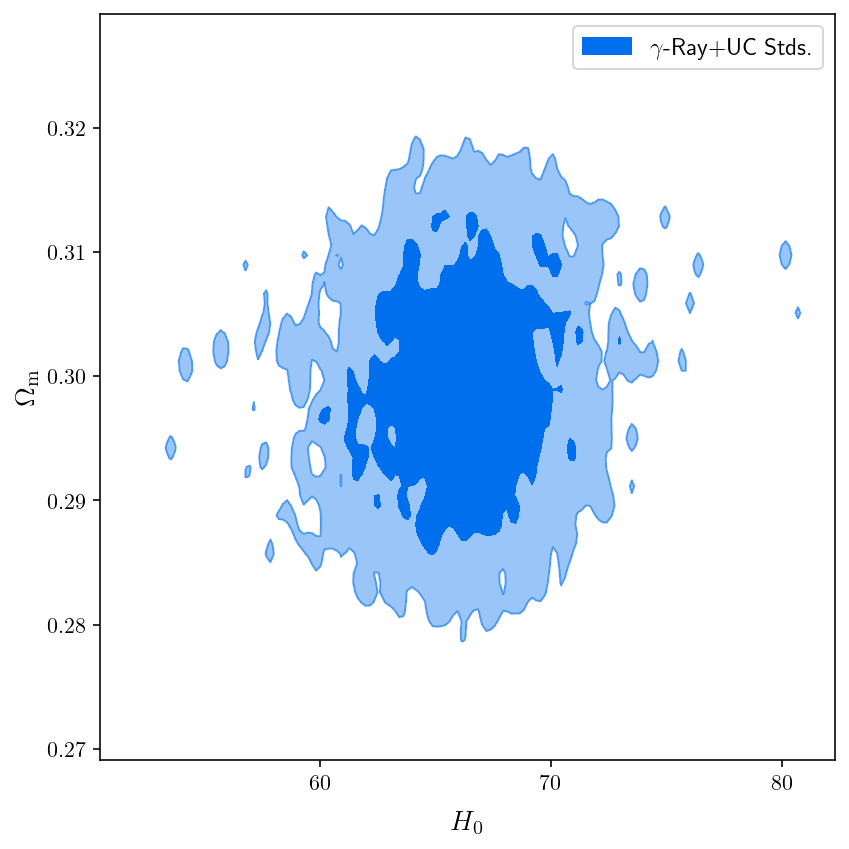

In [840]:
g = plots.getSinglePlotter(ratio=1)
g.sample_analyser.ini.params.update({'smooth_scale_2D':0.5})
# approximation 2
samples_gRay = np.loadtxt('../3STDs/chains_new/g_attenuation2.txt')
weight=[]
Nignore=10000
samples_gRay=samples_gRay[Nignore:,:]
for H0, omegam in zip(samples_gRay[:,1].tolist(),samples_gRay[:,0].tolist()):
    w=np.exp(-((omegam/0.3)*(H0/70)**(-0.08)-1.005281280153786)**2/2/0.02537780952128387**2)
    weight.append(w)

MCsamples_gamma_UCstd_approx = MCSamples(samples=samples_gRay,names = ['omegam','H0'], 
                                labels = [r'\Omega_{\rm{m}}',r'H_0'],weights=np.array(weight))
g.plot_2d(MCsamples_gamma_UCstd_approx, 'H0', 'omegam',filled=True); 
g.add_legend([r'$\gamma$-Ray+UC Stds.'])

print(MCsamples_gamma_UCstd_approx.getMargeStats())


# DES+BBN + All

Removed no burn in


65.28593370560984 3.580034437139679


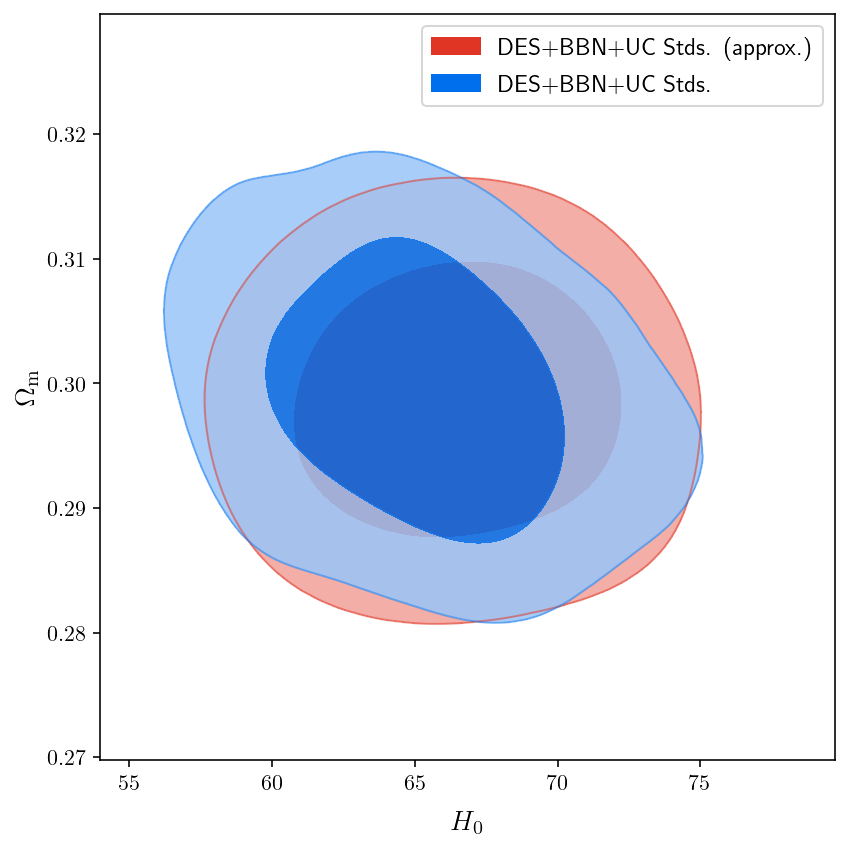

In [834]:
g = plots.getSinglePlotter(ratio=1)
# approximation 2
MCsamples_DES_BBN = loadMCSamples('../3STDs/chains_LSS/DES_withBBN', settings={'ignore_rows':0.3})
p = MCsamples_DES_BBN.getParams() 
weight=[]
for H0, omegam in zip(p.H0.tolist(),p.omegam.tolist()):
    w=np.exp(-((omegam/0.3)*(H0/70)**(-0.08)-1.005281280153786)**2/2/0.02537780952128387**2)
    weight.append(w)

MCsamples_DES_BBN_UCstd_approx2 = MCSamples(samples=MCsamples_DES_BBN.samples[:,[25,27]],names = ['H0','omegam'], 
                                labels = [r'H_0',r'\Omega_{\rm{m}}'],weights=np.array(weight))

MCsamples_DES_BBN_UCstd=loadMCSamples('./chains/LSS_with_UCstds/UCstds_DES_BBN')

g.plot_2d([MCsamples_DES_BBN_UCstd_approx2,MCsamples_DES_BBN_UCstd] ,'H0','omegam',filled=True); 
g.add_legend([r'DES+BBN+UC Stds. (approx.)',r'DES+BBN+UC Stds.'])

print(MCsamples_DES_BBN_UCstd.getMargeStats().parWithName('H0').mean,
      MCsamples_DES_BBN_UCstd.getMargeStats().parWithName('H0').err)

# DES+PlanckCMBlens+BBN+UC stds

Removed no burn in
./chains/LSS_with_UCstds/UCstds_DES_CMBlens_BBN_1.txt
./chains/LSS_with_UCstds/UCstds_DES_CMBlens_BBN_2.txt
Removed no burn in


68.59139909708838 2.18682949914316


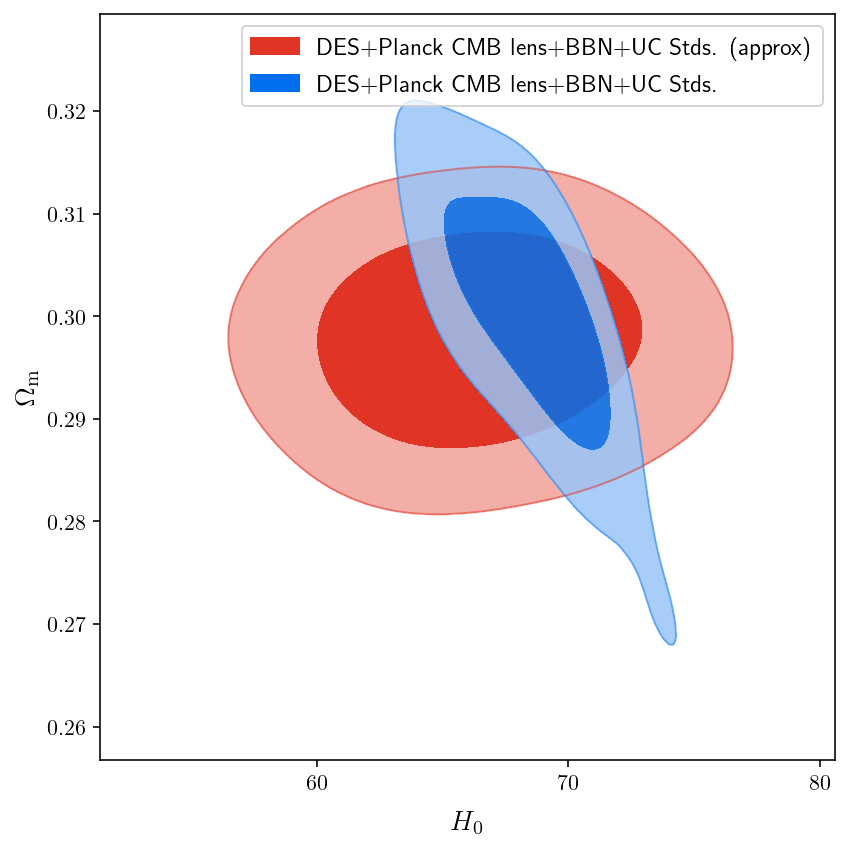

In [842]:
g = plots.getSinglePlotter(ratio=1)
# approximation 2
MCsamples_DES_CMBlens_BBN = loadMCSamples('../3STDs/chains_LSS/CMBlens_DES_withBBNprior_Pantheon')
p = MCsamples_DES_CMBlens_BBN.getParams() 
weight=[]
for H0, omegam in zip(p.H0.tolist(),p.omegam.tolist()):
    w=np.exp(-((omegam/0.3)*(H0/70)**(-0.08)-1.005281280153786)**2/2/0.02537780952128387**2)
    weight.append(w)

MCsamples_DES_CMBlens_BBN_UCstd_approx2 = MCSamples(samples=MCsamples_DES_CMBlens_BBN.samples[:,[25,27]],
                                                    names = ['H0','omegam'], 
                                labels = [r'H_0',r'\Omega_{\rm{m}}'],weights=np.array(weight))

MCsamples_DES_CMBlens_BBN_UCstd=loadMCSamples('./chains/LSS_with_UCstds/UCstds_DES_CMBlens_BBN')

g.plot_2d([MCsamples_DES_CMBlens_BBN_UCstd_approx2,MCsamples_DES_CMBlens_BBN_UCstd] ,'H0','omegam',filled=True); 
g.add_legend([r'DES+Planck CMB lens+BBN+UC Stds. (approx)',r'DES+Planck CMB lens+BBN+UC Stds.'])

print(MCsamples_DES_CMBlens_BBN_UCstd.getMargeStats().parWithName('H0').mean,
      MCsamples_DES_CMBlens_BBN_UCstd.getMargeStats().parWithName('H0').err)

# PCA for all:

In [711]:
samples = np.loadtxt('chains/Default/CMBtheta_BAO/All_UCstds_64_step3000.csv',delimiter=",")
MCsamples = MCSamples(samples=samples,names = names, labels = labels,ranges={'h':(0.55, 0.88)},
                      label='Uncalibrated Cosmic Standards',ignore_rows=2000)
print(MCsamples.getMargeStats())

Marginalized limits: 0.68; 0.95; 0.99

parameter   mean           sddev          lower1         upper1         limit1 lower2         upper2         limit2 lower3         upper3         limit3 
zstar       1.0899394E+03  2.8804142E-01  1.0896635E+03  1.0902216E+03  two    1.0893686E+03  1.0904986E+03  two    1.0891060E+03  1.0906579E+03  two     z_*
rsH0        3.2981857E-02  3.2483022E-04  3.2664182E-02  3.3300256E-02  two    3.2333440E-02  3.3625760E-02  two    3.2125284E-02  3.3836510E-02  two     r_{\rm{s}}H_0
MH0         2.3810752E+01  5.4932963E-03  2.3805282E+01  2.3816202E+01  two    2.3800183E+01  2.3821773E+01  two    2.3796999E+01  2.3825342E+01  two     \mathcal{M}
omegam      3.0148985E-01  7.7243476E-03  2.9383621E-01  3.0910228E-01  two    2.8659869E-01  3.1720981E-01  two    2.8207780E-01  3.2257106E-01  two     \Omega_m
h           6.9995510E-01  9.2390518E-02  5.5000000E-01  7.5003715E-01  >      5.5000000E-01  8.8000000E-01  none   5.5000000E-01  8.8000000E-01  none  

In [625]:
pantheon_path='Pantheon_data/lcparam_full_long_zhel.txt'
pantheon0 = pd.read_csv(pantheon_path, sep=" ", header=0)
pantheon = pantheon0[['name','zcmb','mb','dmb']]
pantheon = pantheon.sort_values(by='zcmb')    # sort SNIa in a z-ascending order for the new algorithm
pantheon = pantheon.reset_index()             # have to reset the index, otherwise the index is not sorted
pan_sys=np.loadtxt("Pantheon_data/sys_full_long_sort.txt")   # systematic errors
C_pan = pan_sys+np.diag(pantheon.dmb**2) # including systematic errors
invC_pan = np.linalg.inv(C_pan)
SN_input=[True,pantheon,invC_pan]  #### change here

# choose from '6df','DR7_MGS','DR12_consensus','DR16_LRG_ELG','DR14_qsar','DR14_lya_qsar'
BAO_input= ['BAO_data/',['6df','DR7_MGS','DR12_consensus','DR16_LRG_ELG','DR14_qsar','DR14_lya_qsar']]

# choose from 'CMB' and 'ACT' for prefix:
CMB_prefix='CMB'   #### specify 
CMB_means = np.loadtxt('CMB_theta/'+CMB_prefix+'_theta_means.txt') # z_re, theta (R optional)
CMB_Cov = np.loadtxt('CMB_theta/'+CMB_prefix+'_theta_Cov.txt')
CMB_invC = np.linalg.inv(CMB_Cov)

if CMB_prefix=='CMB': ##this is for Planck
    theta_cmb=3.0025609E+01
    dtheta_cmb=5.4452421E-01
elif CMB_prefix=='ACT': # this is for ACT:
    theta_cmb=2.9952195E+01
    dtheta_cmb=7.5056623E-01
else:
    print('Invilid CMB prefix.')

CMB_input= [CMB_means,CMB_invC,theta_cmb,dtheta_cmb]

# use CC or not
CC_input=[False,'./CC_data/CC_with_ExtraError.txt'] ## change

def minusln(theta):
    return -2*lnprob_stds_default(theta,SN_input,BAO_input,CMB_input,CC_input)

In [626]:
#
theta=np.array([1.0899547E+03,3.2989309E-02,2.3810823E+01,3.0140794E-01,6.9626169E-01,3.0009614E+01,2.2191584E-02])
epsilon=0.001
fm=np.zeros([len(theta),len(theta)])
minusln0=minusln(theta)
for i in np.arange(len(theta)):
    theta_p=np.copy(theta)  # note that we can't use theta_p=theta otherwise changing one would changes the other
    theta_p[i]=theta[i]*(1+epsilon)
    theta_m=np.copy(theta)
    theta_m[i]=theta[i]*(1-epsilon)
    fm[i,i]=(minusln(theta_p)+minusln(theta_m)-2.0*minusln0)/(theta[i]*epsilon)**2
for i in np.arange(len(theta)):
    for j in np.arange(i+1,len(theta)):
        theta1=np.copy(theta)
        theta1[i]=theta[i]*(1+epsilon)
        theta1[j]=theta[j]*(1+epsilon)
        theta2=np.copy(theta)
        theta2[i]=theta[i]*(1-epsilon)
        theta2[j]=theta[j]*(1+epsilon)
        theta3=np.copy(theta)
        theta3[i]=theta[i]*(1+epsilon)
        theta3[j]=theta[j]*(1-epsilon)
        theta4=np.copy(theta)
        theta4[i]=theta[i]*(1-epsilon)
        theta4[j]=theta[j]*(1-epsilon)
        fm[i,j]=(minusln(theta1)+minusln(theta4)-minusln(theta2)-minusln(theta3))/4/theta[i]/theta[j]/epsilon**2
        fm[j,i]=fm[i,j]
inversefm=np.linalg.inv(fm)
margeC_Om_h=np.copy(inversefm[3:5,3:5])
eigvalues,eigvectors=np.linalg.eig(margeC_Om_h)
eigvectors

array([[-0.99971092, -0.02404331],
       [ 0.02404331, -0.99971092]])

In [627]:
# PCA in log space:
logMeans=np.array([np.log(3.0140794E-01),np.log(6.9626169E-01)])
J=np.diag(logMeans)
margeC_logOm_logh=np.dot(np.dot(J,margeC_Om_h),J)
eigvalues2,eigvectors2=np.linalg.eig(margeC_logOm_logh)
eigvectors2[1,0]/eigvectors2[0,0]

-0.0824743483235081

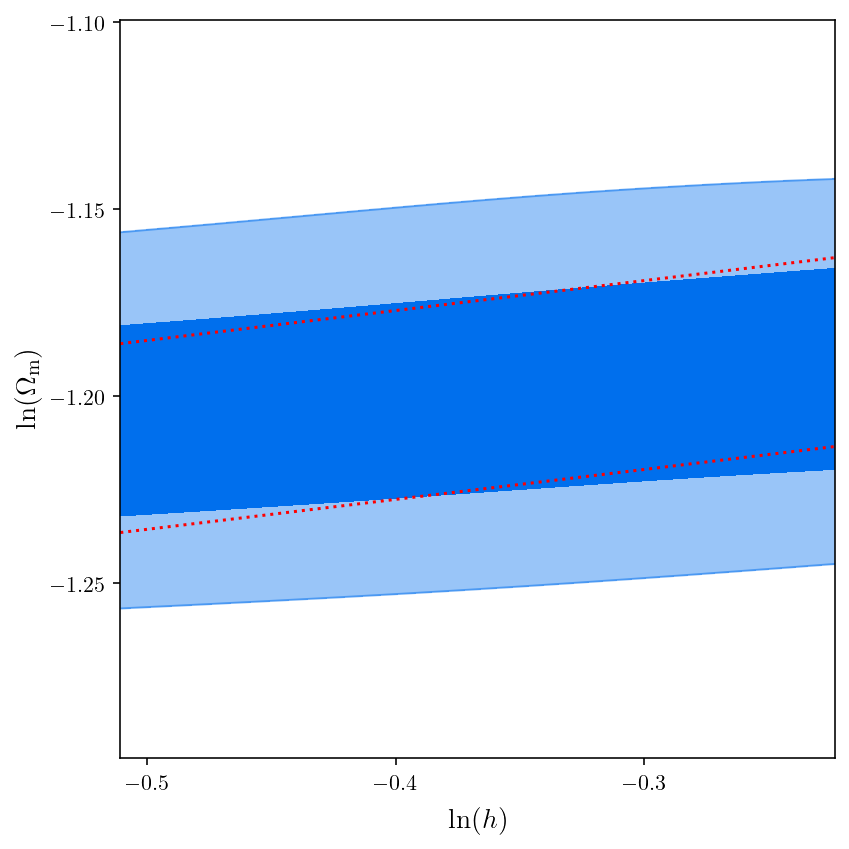

In [807]:
samples = np.loadtxt('chains/Default/CMBtheta_BAO/All_BAO_SN_64_step3000.csv',delimiter=",")
MCsamples = MCSamples(samples=samples,names = names, labels = labels,ranges={'h':(0.6, 0.8)},
                      label='All',ignore_rows=300)
p = MCsamples.getParams() 
MCsamples.addDerived((p.omegam/0.3)*(p.h/0.7)**(-0.08),name='PCA1', label=r'PCA1')
PCA1_mean=MCsamples.getMargeStats().parWithName('PCA1').mean
PCA1_std=MCsamples.std('PCA1')
MCsamples.addDerived(np.log(p.omegam),name='lnOm', label=r'\ln(\Omega_{\rm{m}})')
MCsamples.addDerived(np.log(p.h),name='lnh', label=r'\ln(h)',range=[np.log(0.6),np.log(0.8)])

h_range=np.arange(0.6,0.8,0.01)
Oms_up=(PCA1_mean+PCA1_std)*0.3*(h_range/0.7)**0.08
Oms_low=(PCA1_mean-PCA1_std)*0.3*(h_range/0.7)**0.08

g = plots.getSinglePlotter(ratio=1)

g.plot_2d([MCsamples], 'lnh', 'lnOm',filled=True)
g.add_legend
#g.set_axes(lims=[0.6, 0.8,0.28, 0.335])   # axis limits
plt.plot(np.log(h_range),np.log(Oms_up),color='r',ls=':')
plt.plot(np.log(h_range),np.log(Oms_low),color='r',ls=':')